In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import tensorflow as tf
import time

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [83]:
try:
  data = pd.read_csv('Structured_features.csv')
except:
  print('No such file')

In [84]:
# encode the erbium concentration float value to int
uniq_concent = data["Erbium Concentration"].unique().tolist()
conc_encoded = {x: i for i, x in enumerate(uniq_concent)}

# for later decode use
encoded_to_conc = {i: x for i, x in enumerate(uniq_concent)}
encoded_to_conc

data["Erbium Concentration"] = data["Erbium Concentration"].map(conc_encoded)
data

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity,acoustic impedance,Erbium Concentration
0,60.505571,20.125896,33.671042,50.346610,0.250792,3.343693,2.390885,17.829646,0
1,61.749309,20.539600,34.363176,51.381524,0.250792,3.412425,2.390885,18.196148,0
2,60.206152,20.026301,33.504417,50.097465,0.250792,3.327146,2.390885,17.741414,0
3,62.014179,20.627703,34.510575,51.601922,0.250792,3.427063,2.390885,18.274199,0
4,62.831822,20.899675,34.965589,52.282281,0.250792,3.472248,2.390885,18.515140,0
...,...,...,...,...,...,...,...,...,...
245,58.273308,19.835527,31.825938,49.270607,0.241979,3.411991,2.493001,17.663388,4
246,57.141365,19.450228,31.207728,48.313539,0.241979,3.345714,2.493001,17.320282,4
247,61.777979,21.028475,33.740012,52.233838,0.241979,3.617195,2.493001,18.725699,4
248,58.251540,19.828118,31.814050,49.252202,0.241979,3.410717,2.493001,17.656790,4


In [85]:
column_name = data.columns[:-1]
column_name

Index(['Longitudinal modulus', 'Shear modulus', 'Bulk modulus',
       'Young modulus', 'Poisson's ratio', 'Hardness',
       'fractal bond connectivity', 'acoustic impedance'],
      dtype='object')

In [89]:
df_data = data.copy()
for column in column_name:
    df_data[column] = (df_data[column] - df_data[column].min()) / (df_data[column].max() - df_data[column].min())
df_data

,Longitudinal modulus,Shear modulus,Bulk modulus,Young modulus,Poisson's ratio,Hardness,fractal bond connectivity,acoustic impedance,Erbium Concentration
0,0.402600,0.447432,0.450173,0.422583,0.643648,0.426756,0.282833,0.383823,0
1,0.450058,0.500519,0.486700,0.477551,0.643648,0.460885,0.282833,0.436787,0
2,0.391175,0.434652,0.441379,0.409349,0.643648,0.418540,0.282833,0.371072,0
3,0.460165,0.511824,0.494479,0.489257,0.643648,0.468153,0.282833,0.448067,0
4,0.491364,0.546724,0.518492,0.525394,0.643648,0.490590,0.282833,0.482886,0
...,...,...,...,...,...,...,...,...,...
245,0.317422,0.410172,0.352798,0.365432,0.556935,0.460670,0.354152,0.359796,4
246,0.274230,0.360730,0.320173,0.314598,0.556935,0.427760,0.354152,0.310213,4
247,0.451152,0.563252,0.453813,0.522821,0.556935,0.562564,0.354152,0.513314,4
248,0.316592,0.409221,0.352171,0.364454,0.556935,0.460037,0.354152,0.358843,4


In [154]:
train_dataset = df_data.sample(frac=0.8, random_state=0)
test_dataset = df_data.drop(train_dataset.index)

# Collect input feature for training, molar volume value in this case
train_features = train_dataset.copy() #dataframe type
test_features = test_dataset.copy()

# Collect respective label, density value in this case
train_labels = train_features.pop('Erbium Concentration') # series type
test_labels = test_features.pop('Erbium Concentration')

In [91]:
for i in range(10):  
  sgd_classifier = SGDClassifier(
                                max_iter=300,
                                learning_rate='constant',
                                loss='squared_hinge',
                                validation_fraction=0.2,
                                early_stopping=True,
                                eta0=0.001,
                                ).fit(train_features, train_labels)

  pred_y = sgd_classifier.predict(test_features)
  train_acc = sgd_classifier.score(train_features, train_labels)
  test_acc = sgd_classifier.score(test_features, test_labels)

  print('Training Accuracy : %.3f'%train_acc)
  print('Test Accuracy : %.3f'%test_acc)

Training Accuracy : 0.390
Test Accuracy : 0.240
Training Accuracy : 0.375
Test Accuracy : 0.240
Training Accuracy : 0.340
Test Accuracy : 0.240
Training Accuracy : 0.355
Test Accuracy : 0.240
Training Accuracy : 0.350
Test Accuracy : 0.160
Training Accuracy : 0.330
Test Accuracy : 0.160
Training Accuracy : 0.320
Test Accuracy : 0.200
Training Accuracy : 0.375
Test Accuracy : 0.240
Training Accuracy : 0.360
Test Accuracy : 0.240
Training Accuracy : 0.380
Test Accuracy : 0.220


In [92]:
y_true, y_pred = test_labels , sgd_classifier.predict(test_features)

print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.26      0.62      0.37         8
           1       0.00      0.00      0.00        11
           2       0.21      0.75      0.33         8
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        12

    accuracy                           0.22        50
   macro avg       0.10      0.28      0.14        50
weighted avg       0.08      0.22      0.11        50



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy score : 0.22


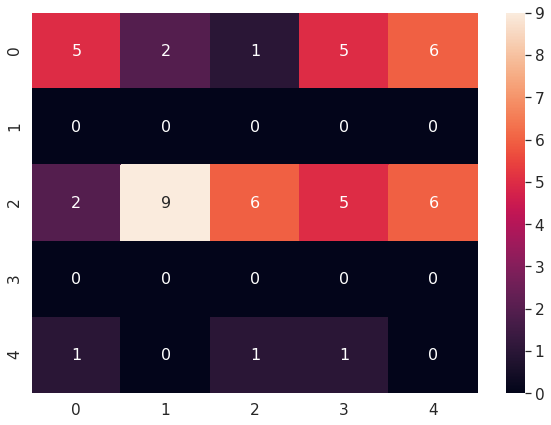

In [93]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

plt.figure(figsize=(10,7))
cm = confusion_matrix(pred_y, test_labels)
print("Accuracy score :", accuracy(cm))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16})
plt.show()

# **Feature Selection**

In [94]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

num_select = 5
X = data[column_name]
y = data['Erbium Concentration']
selected_features = SelectKBest(score_func=chi2, k=num_select)
fit = selected_features.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(num_select,'Score'))

                  Specs     Score
2          Bulk modulus  6.292307
0  Longitudinal modulus  5.062600
3         Young modulus  2.813917
1         Shear modulus  1.140136
7    acoustic impedance  0.958431


[0.07516638 0.07221378 0.10254274 0.07123773 0.2598738  0.11248382
 0.22507262 0.08140912]


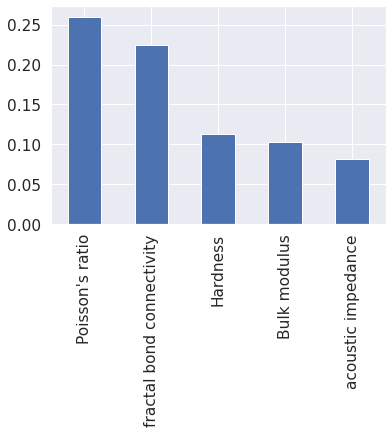

In [95]:
from sklearn.ensemble import ExtraTreesClassifier

extract_tree = ExtraTreesClassifier()
extract_tree.fit(X,y)

print(extract_tree.feature_importances_)
feat_importances = pd.Series(extract_tree.feature_importances_, index=X.columns)
feat_importances.nlargest(num_select).plot(kind='bar')
plt.show()

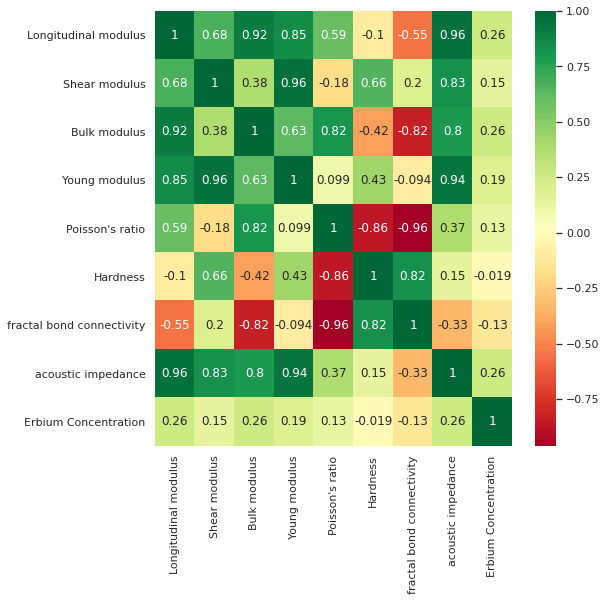

In [96]:
corrmat = data.corr()
top_corr_features = corrmat.index
sns.set(font_scale=1.0)
plt.figure(figsize=(8,8))
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [127]:
# filtered_df_data = df_data.drop(['Hardness','fractal bond connectivity'], axis=1)
filtered_df_data = df_data[['Longitudinal modulus','Bulk modulus','acoustic impedance','Erbium Concentration']]
filtered_df_data

,Longitudinal modulus,Bulk modulus,acoustic impedance,Erbium Concentration
0,0.402600,0.450173,0.383823,0
1,0.450058,0.486700,0.436787,0
2,0.391175,0.441379,0.371072,0
3,0.460165,0.494479,0.448067,0
4,0.491364,0.518492,0.482886,0
...,...,...,...,...
245,0.317422,0.352798,0.359796,4
246,0.274230,0.320173,0.310213,4
247,0.451152,0.453813,0.513314,4
248,0.316592,0.352171,0.358843,4


Training Accuracy : 0.250
Test Accuracy : 0.180
Accuracy score : 0.18


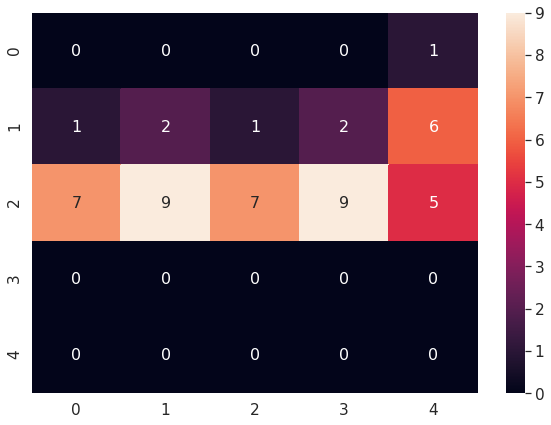

In [152]:
filtered_train_dataset = filtered_df_data.sample(frac=0.8, random_state=0)
filtered_test_dataset = filtered_df_data.drop(filtered_train_dataset.index)

# Collect input feature for training, molar volume value in this case
filtered_train_features = filtered_train_dataset.copy() #dataframe type
filtered_test_features = filtered_test_dataset.copy()

# Collect respective label, density value in this case
filtered_train_labels = filtered_train_features.pop('Erbium Concentration') # series type
filtered_test_labels = filtered_test_features.pop('Erbium Concentration')

filter_sgd_classifier = SGDClassifier(
                              max_iter=200,
                              learning_rate='optimal',
                              loss='squared_hinge',
                              validation_fraction=0.3,
                              ).fit(np.array(filtered_train_features), np.array(filtered_train_labels))

filtered_pred_y = filter_sgd_classifier.predict(np.array(filtered_test_features))
filtered_train_acc = filter_sgd_classifier.score(np.array(filtered_train_features), np.array(filtered_train_labels))
filtered_test_acc = filter_sgd_classifier.score(np.array(filtered_test_features), np.array(filtered_test_labels))

print('Training Accuracy : %.3f'%filtered_train_acc)
print('Test Accuracy : %.3f'%filtered_test_acc)

plt.figure(figsize=(10,7))
filtered_cm = confusion_matrix(filtered_pred_y, np.array(filtered_test_labels))
print("Accuracy score :", accuracy(filtered_cm))
sns.set(font_scale=1.4) # for label size
sns.heatmap(filtered_cm, annot=True, annot_kws={"size": 16})
plt.show()

In [155]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

score_mean = []
score_std = []

split_num = 7

for i in range(2, split_num):
  # create a KFold object with n splits 
  kf = KFold(n_splits = i, shuffle = True, random_state = 10)
  scores = cross_val_score(filter_sgd_classifier, filtered_train_features, filtered_train_labels, cv=kf)
  m = np.mean(scores)
  s = np.std(scores)
  score_mean.append(m)
  score_std.append(s)
  print('Number of splits: %d, Accuracy: %.3f, Standard Devidation: %.3f' % (i, m, s))

Number of splits: 2, Accuracy: 0.225, Standard Devidation: 0.055
Number of splits: 3, Accuracy: 0.255, Standard Devidation: 0.026
Number of splits: 4, Accuracy: 0.270, Standard Devidation: 0.112
Number of splits: 5, Accuracy: 0.250, Standard Devidation: 0.101
Number of splits: 6, Accuracy: 0.201, Standard Devidation: 0.077


In [114]:
parameter_space = {
    'max_iter': [50, 100, 200, 300, 400, 500],
}

clf = GridSearchCV(filter_sgd_classifier, parameter_space, n_jobs=-1, cv=5)
clf.fit(filtered_train_features, filtered_train_labels)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.250 (+/-0.063) for {'max_iter': 50}
0.220 (+/-0.080) for {'max_iter': 100}
0.225 (+/-0.063) for {'max_iter': 200}
0.185 (+/-0.040) for {'max_iter': 300}
0.250 (+/-0.095) for {'max_iter': 400}
0.215 (+/-0.068) for {'max_iter': 500}
